# Process Stations

In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pkg_resources import resource_filename

from climpyrical.gridding import transform_coords, find_element_wise_nearest_pos, scale_model_obs
from scipy.interpolate import NearestNDInterpolator

### Load station data for processing

In [2]:
# station_dv = 'RL50 (kPa)'
# station_dv = 'mean RH (%)'
# station_dv = 'SL50 (kPa)'
# station_dv = 'TJan2.5 (degC)'
station_dv = 'HDD (degC-day)'
# station_dv = 'Q10_Gumbel-MM'
# station_dv = 'Q50_Gumbel-MM'

paths = {
    'RL50 (kPa)': 'nrc_data/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv',
    'mean RH (%)': 'nrc_data/rh_annual_mean_10yr_for_maps.csv',
    'HDD (degC-day)': 'nrc_data/Interim_hdd_Tmax_Tmin_delivered.csv',
    'SL50 (kPa)': 'nrc_data/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv',
    'Q10_Gumbel-MM': 'nrc_data/wpress_stations_rl10_rl50.csv',
    'TJan2.5 (degC)': 'nrc_data/janT2.5p_T1.0p_allstations_v2_for_maps.csv',
    'TJan1.0 (degC)': 'nrc_data/janT2.5p_T1.0p_allstations_v2_for_maps.csv'
}

DF_PATH = resource_filename(
    'climpyrical',
    paths[station_dv]
)

df = pd.read_csv(DF_PATH, index_col=None).dropna()

# transform into rotated pole and assign as new columns
rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values)

df = df.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)

# Create array of mean
if 'degC' in station_dv and not 'degC-day' in station_dv:
    df[station_dv] = df[station_dv].values + 273.15
else:
    df[station_dv] = df[station_dv].values

file_dv = station_dv.split(' ')[0]

if 'RL50' in station_dv:
    df = df[df[station_dv] != 0.0]
    assert not np.any(np.isclose(df[station_dv].values, 0.0))

/home/nannau/tri/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Open the pre-processed model

In [3]:
pre_processed_path = resource_filename(
    "climpyrical", 
    "/nrc_data/processed/pre_processed.nc"
)

ds = xr.open_dataset(pre_processed_path)
dv = list(ds.data_vars)[0]

### Match stations to grids in model
Find the nearest grid cells to the station locations

In [4]:
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values, 
            df.rlon.values, 
            df.rlat.values
)

matched_df = pd.DataFrame({'ilocy': iy, 'ilocx': ix, station_dv: df[station_dv], 'rlat':df.rlat, 'rlon':df.rlon, 'lat': df.lat, 'lon':df.lon, 'station_name':df.station_name})
matched_df = matched_df.groupby(['ilocy', 'ilocx'], as_index=False).agg({station_dv: 'mean', 'rlat':'mean', 'rlon':'mean', 'lat': 'mean', 'lon': 'mean', 'station_name': 'first'})

iy = matched_df.ilocy.values
ix = matched_df.ilocx.values
station_vals = matched_df[station_dv].values

Identify locations where the closest grid cell falls on a invalid model value

In [5]:
nan_index = np.isnan(ds[dv].values[iy, ix])
ixnan, iynan = matched_df.ilocx.values[nan_index], matched_df.ilocy.values[nan_index]
ixnan, iynan

(array([], dtype=int64), array([], dtype=int64))

Create an interpolator that can find the nearest valid model value at these locations

In [6]:
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

model_nan = ~np.isnan(ds[dv])
model_vals = ds[dv].values[iy, ix]

f = NearestNDInterpolator(np.stack([rlon[model_nan], rlat[model_nan]]).T, ds[dv].values[model_nan])

Replace those invalid values with their nearest neighbor based on above interpolator.

In [7]:
model_vals[nan_index] = f(np.stack([rlon[iynan, ixnan], rlat[iynan, ixnan]]).T)

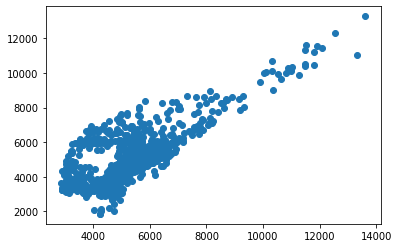

In [8]:
plt.scatter(station_vals, model_vals)

Now each station should be matched with a value grid cell value

In [9]:
ratio = matched_df[station_dv]/model_vals
assert not np.any(np.isnan(ratio))

### Normalize the model mean to match that of the station distribution
Find a factor, $\beta$ such that the model mean $$\frac{\mu_m}{\beta} \approx \mu_s$$ where $\mu_s$ is the station mean. 

In [10]:
# calculate ratios with applied correction
ratio, best_tol = scale_model_obs(model_vals, station_vals)
matched_df = matched_df.assign(ratio=ratio)

In [11]:
matched_df = matched_df.assign(model_vals = model_vals, best_tol = best_tol)

In [12]:
df_path_write = resource_filename('climpyrical', '/nrc_data/processed/processed_station.csv')
matched_df.to_csv(df_path_write)

matched_df.to_csv(f'~/dash-dv-explorer/assets/data/stations/{file_dv}_stations.csv')

In [13]:
matched_df.head()

,ilocy,ilocx,HDD (degC-day),rlat,rlon,lat,lon,station_name,ratio,model_vals,best_tol
0,552,1011,3829.15,-4.517790,10.457750,42.0333,-82.9000,HARROW CDA,1.192796,2973.975594,0.926406
1,552,1017,3734.15,-4.547677,10.753982,41.9500,-82.5167,POINT PELEE,1.212751,2852.472486,0.926406
2,553,1007,3635.15,-4.474659,10.302673,42.1034,-83.0945,AMHERSTBURG,1.097154,3069.419146,0.926406
3,557,1013,3672.15,-4.315023,10.546376,42.2167,-82.7333,WOODSLEE CDA AUTOMATIC CLIMATE STATION,1.116152,3047.884345,0.926406
4,558,1009,3652.15,-4.286849,10.373390,42.2756,-82.9556,WINDSOR A,1.078551,3136.962689,0.926406


In [14]:
assert np.all(matched_df['ratio'] > 0)

# Process NRC Locations

In [15]:
nrc_path = '/home/nannau/nrc_data/NBCC_2020_new_coords.xlsm'
df_nrc = pd.read_excel(nrc_path).dropna()

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# get rotated pole coordinates
rlon_st, rlat_st = transform_coords(df_nrc['2020 Longitude'].values, df_nrc['2020 Latitude'].values)
df_nrc = df_nrc.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)

/home/nannau/tri/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [16]:
# find indices of the station locations
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values, 
            df_nrc.rlon.values, 
            df_nrc.rlat.values
)
# write to new dataframe
df_nrc_matched = pd.DataFrame(
    {'ilocy': iy, 
     'ilocx': ix, 
     'Location': df_nrc.Location, 
     'rlat':df_nrc.rlat, 
     'rlon':df_nrc.rlon, 
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
)

df_nrc_matched.to_csv('./data/processed/nrc_locations.csv')